We will now construct an actual cnn and not only layer by layer traversing, all of these are from the previous notebook coded as is these are basic requirements.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
data_dir = "Data/mnist"
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.54MB/s]


Now we can construct the skeleton.

In [2]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X)) #second pass
        X = F.max_pool2d(X,2,2)
        X = X.view(-1, 16*5*5) #flattening
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return F.log_softmax(X, dim=1)



Now we will create an instance of our created model starting by setting a manual seed

In [3]:
torch.manual_seed(41)
model = cnn()
print(model)

cnn(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Now loss function and optimizer CrossEnropyLoss and Adam optimizer as used before. Here smaller the learning rate, longer it'll take to train

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

Moving onto training and testing now. Time we'll use to see how long our CNN will take to run. Now we are going to keep track of our losses and correctness as we move forward in this program

In [5]:
import time
start_time = time.time()
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
for i in range(epochs):
    train_cor = 0
    test_cor = 0
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_cor = (predicted == y_train).sum()
        train_cor+=batch_cor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (b%600 == 0):
            print(f'epoch: {i} batch: {b} loss: {loss.item()}'
            )
    train_losses.append(loss)
    train_correct.append(train_cor)
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_cor+= (predicted == y_test).sum()
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_cor)
current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} mins')

epoch: 0 batch: 600 loss: 1.0163131952285767
epoch: 1 batch: 600 loss: 0.8801957368850708
epoch: 2 batch: 600 loss: 1.2360751628875732
epoch: 3 batch: 600 loss: 1.046932339668274
epoch: 4 batch: 600 loss: 1.0566174983978271
Training took: 1.8289609670639038 mins


Now to graph these results basically graph the losses, before that convert the nmupy arrays to python lists

In [6]:
train_losses = [tl.item() for tl in train_losses]
test_losses = [tl.item() for tl in test_losses]

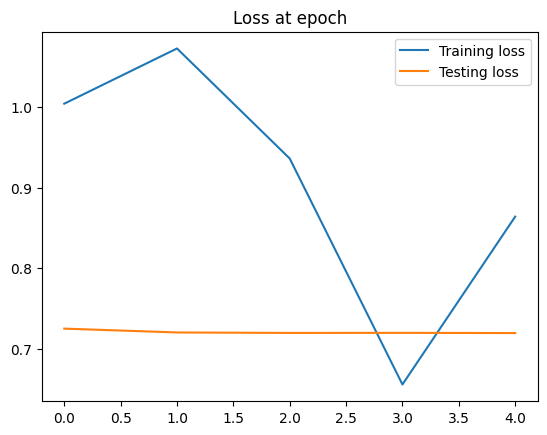

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.title('Loss at epoch')
plt.legend()